This notebook is intended for someone to be able to generate a model that is finetuned to identify images of different species of birds. 

In [ ]:
#uncomment lines here to install any missing dependencies
#!pip install datasets, transformers, hugginface_hub #hugginface packages
#!pip install numpy
#!pip install torch torchvision torchaudio #pytorch packages
#ipip install accelerate == 0.28.0 #this specific version is needed to prevent errors

#package versions I use:
#datasets 3.5.0 ; accelerate = 0.28.0 ; transformers = 4.33.3 ; 
#torch = 2.5.1 ; torchvision = 0.20.1; 
#huggingface_hub = 0.30.1 ;
#numpy = 1.25.2 ;

#python version is 3.11.8

Here is where you will be importing the packages required for this project. 

In [ ]:
from datasets import load_dataset, Image, load_metric
from torchvision.transforms.v2 import Compose, ColorJitter, ToTensor, RandomRotation, RandomPerspective
from torch.utils.data import DataLoader
import torchvision.transforms.functional as F
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer, AutoImageProcessor, AutoFeatureExtractor
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from huggingface_hub import notebook_login
import torch

The notebook_login() part is only required if you plan to upload your finished model to HuggingFace once it is generated. If you do not plan to do this comment out notebook_login() and there will be a line that must be changed further on in this package.

In [188]:
notebook_login()

In [ ]:
dataset = load_dataset("bentrevett/caltech-ucsd-birds-200-2011") #Here I have loaded in a dataset of images of birds
#this dataset is from the Huggingface datasets library and was produced by CalTech and UCSD
#It contains 11,788 images of birds from 200 different species
# It is split in half for training and testing

In [ ]:
dataset = dataset.cast_column("image", Image(mode="RGB")) #loading in the images as RGB images

In [191]:
dataset["train"].features #this is the training aspect of the dataset and its features (it's composed of images, labels of bird in image, and a bounding box)

{'image': Image(mode='RGB', decode=True, id=None),
 'label': ClassLabel(names=['001.Black_footed_Albatross', '002.Laysan_Albatross', '003.Sooty_Albatross', '004.Groove_billed_Ani', '005.Crested_Auklet', '006.Least_Auklet', '007.Parakeet_Auklet', '008.Rhinoceros_Auklet', '009.Brewer_Blackbird', '010.Red_winged_Blackbird', '011.Rusty_Blackbird', '012.Yellow_headed_Blackbird', '013.Bobolink', '014.Indigo_Bunting', '015.Lazuli_Bunting', '016.Painted_Bunting', '017.Cardinal', '018.Spotted_Catbird', '019.Gray_Catbird', '020.Yellow_breasted_Chat', '021.Eastern_Towhee', '022.Chuck_will_Widow', '023.Brandt_Cormorant', '024.Red_faced_Cormorant', '025.Pelagic_Cormorant', '026.Bronzed_Cowbird', '027.Shiny_Cowbird', '028.Brown_Creeper', '029.American_Crow', '030.Fish_Crow', '031.Black_billed_Cuckoo', '032.Mangrove_Cuckoo', '033.Yellow_billed_Cuckoo', '034.Gray_crowned_Rosy_Finch', '035.Purple_Finch', '036.Northern_Flicker', '037.Acadian_Flycatcher', '038.Great_Crested_Flycatcher', '039.Least_Flycat

In [ ]:
train_dataset = dataset["train"] #define the training dataset 

In [ ]:
labels = dataset['train'].features["label"].names #labels the dataset uses, the 200 bird species

32 033.Yellow_billed_Cuckoo


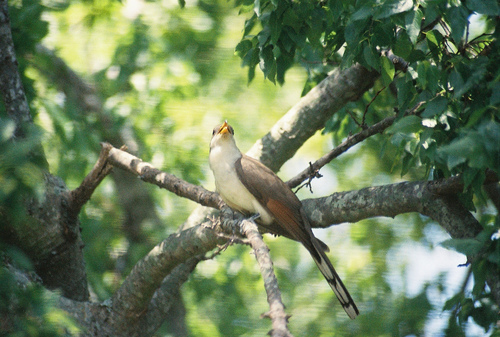

In [194]:
example = dataset["train"][987] #this is a random example of the dataset
print(example['label'], labels[example['label']]) #printing the label number and then the actual label
example['image'] #displaying the image


Here is when I load in from HuggingFace the model checkpoint I will be using, it's a general computer vision model called ViT and is produced by Google. There is an alternate version of this notebook that loads in an alternate model checkpoint called Swin.

In [ ]:
model_checkpoint = "google/vit-base-patch16-224" #this is the model checkpoint I am using, it is a pretrained model from google

image_processor = AutoImageProcessor.from_pretrained(model_checkpoint) #this is the image processor that will be used to process the images


/Users/robertcf/miniconda3/envs/general/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


As a form of modifying the images to create a bit more of a robust image training dataset I apply a random perspective transformation to the images (my base reasoning is you see birds from odd angles in your day to day life). It is applied below. 

In [ ]:
perspective = Compose([RandomPerspective(distortion_scale=0.5, p=.8)])  
#this is the perspective transform that will be used to augment the images

In [ ]:
train_dataset = dataset["train"] #this is the training half of the dataset
evaluate_dataset = dataset["test"] #this is the testing half of the dataset

In [ ]:
def transforms(examples): #this function applies the perspective transform to the images
    perps = [perspective(image) for image in examples["image"]]
    inputs = image_processor(perps, return_tensors="pt") #it also puts them through the image processor
    inputs["label"] = examples["label"] #this imageprocessor will make everything into a tensor with normalized pixel values
    return inputs

In [ ]:
train_dataset = train_dataset.with_transform(transforms) #this applies the transforms to the training dataset
evaluate_dataset = evaluate_dataset.with_transform(transforms) #this applies the transforms to the testing dataset

In [ ]:
def collate_fn(examples): #this function collates the examples into a batch for the batch size I specify 
    pixel_values = torch.stack([x['pixel_values'] for x in examples])
    labels = torch.tensor([x['label'] for x in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [202]:
metric = load_metric("accuracy") #this is the accuracy metric that will be used to evaluate the model
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1) #this is the predicted labels
    return metric.compute(predictions=preds, references=p.label_ids) #this is the accuracy of the model



/Users/robertcf/miniconda3/envs/general/lib/python3.11/site-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
label2id, id2label = dict(), dict() #this is the label to id and id to label dictionary
for i, label in enumerate(labels):
    label2id[label] = i #so if i feed in a label it will return the id
    id2label[i] = label #or if i feed in an id it will return the label

This is where the model we will train is actually first made:

In [204]:
model = AutoModelForImageClassification.from_pretrained(model_checkpoint, #this is the model that will be used to classify the images
                                                        id2label=id2label, 
                                                        label2id=label2id,
                                                        ignore_mismatched_sizes = True) 
#ignore_mismatched_sizes is used to ignore the size mismatch between the model and the dataset
#fine to ignore it as I am using a pretrained model and the dataset is not the same size as the model

/Users/robertcf/miniconda3/envs/general/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([200]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([200, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [205]:
model.classifier = nn.Linear(in_features=model.classifier.in_features, out_features=len(labels))
#this is the classifier that will be used to classify the images
#the in_features is the number of input features and the out_features is the number of output features


This is where we specificy how we will be training the model. If you do not plan to push the fine tuned model to HuggingFace, please change push_to_hub at the bottom of this from True to False. 

The no_cuda line should be changed from True to False if you are able to use a GPU to accelerate the training of this model.

In [206]:
training_arguments = TrainingArguments( #these training arguements are how the model will train itself   
    output_dir="vit-bird", #like how many iterations/epochs it will run, how much it iterates between these, how much it saves, etc.
    per_device_train_batch_size=8, #batch size for training, so batch 8 iamages together
    remove_unused_columns=False, #this will keep unused columns in the dataset
    evaluation_strategy = "epoch", #this is how often the model will evaluate itself
    save_strategy = "epoch",
    learning_rate=5e-5,# #this is the learning rate of the model, how fast it will learn
    save_total_limit=2, #this is how many models it will save
    gradient_accumulation_steps=4, #this is how many steps the model will take before updating the weights
    per_device_eval_batch_size=8, #batch size for evaluation
    num_train_epochs=3, #will run it for 3 epochs
    warmup_ratio=0.1, #this is the ratio of the total training steps that will be used for a linear warmup
    fp16=False, #this is used to speed up the training process, but dont have gpu for it
    logging_steps=10, #this is how often the model will log its progress
    load_best_model_at_end=True, #this will load the best model at the end of training
    metric_for_best_model="accuracy",
    no_cuda = True, #makes it use CPU as my computer has an integrated graphics card
    push_to_hub= True #save it to the huggingface hub
 )


/Users/robertcf/miniconda3/envs/general/lib/python3.11/site-packages/transformers/training_args.py:1257: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


In [ ]:
trainer = Trainer( #here we actually define the trainer that wil ltrain the model
    model, #this is the model that will be used to train the images
    training_arguments, #these are the training arguments that will be used to train the model
    train_dataset=train_dataset, #this is the training dataset that will be used to train the model
    eval_dataset=evaluate_dataset, #this is the evaluation dataset that will be used to evaluate the model
    compute_metrics=compute_metrics,  #this is the function that will be used to compute the metrics of the model
    tokenizer=image_processor, #this is the tokenizer that will be used to tokenize the images
    data_collator=collate_fn, #this is the data collator that will be used to collate the data
)

/Users/robertcf/miniconda3/envs/general/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Here is where we train the model. It took ~1.5 hours for me to train this model

In [208]:
train_results = trainer.train()

  0%|          | 0/561 [00:00<?, ?it/s]

{'loss': 5.4308, 'learning_rate': 8.771929824561403e-06, 'epoch': 0.05}
{'loss': 5.4379, 'learning_rate': 1.7543859649122806e-05, 'epoch': 0.11}
{'loss': 5.3419, 'learning_rate': 2.6315789473684212e-05, 'epoch': 0.16}
{'loss': 5.272, 'learning_rate': 3.508771929824561e-05, 'epoch': 0.21}
{'loss': 5.1466, 'learning_rate': 4.3859649122807014e-05, 'epoch': 0.27}
{'loss': 5.065, 'learning_rate': 4.9702380952380955e-05, 'epoch': 0.32}
{'loss': 4.9301, 'learning_rate': 4.871031746031746e-05, 'epoch': 0.37}
{'loss': 4.7523, 'learning_rate': 4.771825396825397e-05, 'epoch': 0.43}
{'loss': 4.5793, 'learning_rate': 4.672619047619048e-05, 'epoch': 0.48}
{'loss': 4.475, 'learning_rate': 4.573412698412698e-05, 'epoch': 0.53}
{'loss': 4.3559, 'learning_rate': 4.4742063492063494e-05, 'epoch': 0.59}
{'loss': 4.119, 'learning_rate': 4.375e-05, 'epoch': 0.64}
{'loss': 4.0739, 'learning_rate': 4.2757936507936505e-05, 'epoch': 0.69}
{'loss': 3.8947, 'learning_rate': 4.176587301587302e-05, 'epoch': 0.75}
{'

  0%|          | 0/725 [00:00<?, ?it/s]

{'eval_loss': 3.1595356464385986, 'eval_accuracy': 0.5787021056265101, 'eval_runtime': 468.0472, 'eval_samples_per_second': 12.379, 'eval_steps_per_second': 1.549, 'epoch': 1.0}
{'loss': 3.1562, 'learning_rate': 3.6805555555555556e-05, 'epoch': 1.01}
{'loss': 2.9158, 'learning_rate': 3.581349206349207e-05, 'epoch': 1.07}
{'loss': 2.7023, 'learning_rate': 3.4821428571428574e-05, 'epoch': 1.12}
{'loss': 2.7148, 'learning_rate': 3.3829365079365086e-05, 'epoch': 1.17}
{'loss': 2.7237, 'learning_rate': 3.283730158730159e-05, 'epoch': 1.23}
{'loss': 2.5637, 'learning_rate': 3.1845238095238096e-05, 'epoch': 1.28}
{'loss': 2.4367, 'learning_rate': 3.085317460317461e-05, 'epoch': 1.33}
{'loss': 2.4197, 'learning_rate': 2.9861111111111113e-05, 'epoch': 1.39}
{'loss': 2.3834, 'learning_rate': 2.886904761904762e-05, 'epoch': 1.44}
{'loss': 2.3557, 'learning_rate': 2.787698412698413e-05, 'epoch': 1.49}
{'loss': 2.2529, 'learning_rate': 2.6884920634920636e-05, 'epoch': 1.55}
{'loss': 2.2387, 'learni

  0%|          | 0/725 [00:00<?, ?it/s]

{'eval_loss': 1.933510184288025, 'eval_accuracy': 0.7390403866068347, 'eval_runtime': 515.0168, 'eval_samples_per_second': 11.25, 'eval_steps_per_second': 1.408, 'epoch': 2.0}
{'loss': 1.771, 'learning_rate': 1.7956349206349207e-05, 'epoch': 2.03}
{'loss': 1.5888, 'learning_rate': 1.6964285714285715e-05, 'epoch': 2.08}
{'loss': 1.6584, 'learning_rate': 1.597222222222222e-05, 'epoch': 2.13}
{'loss': 1.638, 'learning_rate': 1.498015873015873e-05, 'epoch': 2.19}
{'loss': 1.5798, 'learning_rate': 1.398809523809524e-05, 'epoch': 2.24}
{'loss': 1.5108, 'learning_rate': 1.2996031746031748e-05, 'epoch': 2.29}
{'loss': 1.5546, 'learning_rate': 1.2003968253968255e-05, 'epoch': 2.35}
{'loss': 1.5164, 'learning_rate': 1.1011904761904762e-05, 'epoch': 2.4}
{'loss': 1.4779, 'learning_rate': 1.001984126984127e-05, 'epoch': 2.45}
{'loss': 1.5285, 'learning_rate': 9.027777777777777e-06, 'epoch': 2.51}
{'loss': 1.5362, 'learning_rate': 8.035714285714286e-06, 'epoch': 2.56}
{'loss': 1.4654, 'learning_rat

  0%|          | 0/725 [00:00<?, ?it/s]

{'eval_loss': 1.6612292528152466, 'eval_accuracy': 0.7652744218156714, 'eval_runtime': 523.7322, 'eval_samples_per_second': 11.063, 'eval_steps_per_second': 1.384, 'epoch': 2.99}


/Users/robertcf/miniconda3/envs/general/lib/python3.11/site-packages/transformers/trainer.py:2190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best

{'train_runtime': 5223.7166, 'train_samples_per_second': 3.442, 'train_steps_per_second': 0.107, 'train_loss': 2.767083219028412, 'epoch': 2.99}


Here we save the model and display final metrics such as time it took train, how many samples it trains a second, and the final loss that was achieved. 

In [209]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =       2.99
  train_loss               =     2.7671
  train_runtime            = 1:27:03.71
  train_samples_per_second =      3.442
  train_steps_per_second   =      0.107


Here I then evaluate the trained model on the evaluation dataset I defined earlier in the notebook. This tests how good the model is. In the end I achieve only an accuracy of 76.51%. I would have liked a higher accuracy but it would take much more computational time on my laptop (and my laptop has a difficult time doing anything else while this is running).

If you wish to have a more accurrate model feel free changing things such as how many epochs this runs for or how often the priors are updated while evaluating. 

In [ ]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

  0%|          | 0/725 [00:00<?, ?it/s]

***** eval metrics *****
  epoch                   =       2.99
  eval_accuracy           =     0.7651
  eval_loss               =     1.6678
  eval_runtime            = 0:08:27.05
  eval_samples_per_second =     11.427
  eval_steps_per_second   =       1.43
